In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os
 
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [4]:
from zipfile import ZipFile

data_path = r'C:\Users\nishantjairath\Downloads\lung_colon_image_set.zip'

with ZipFile(data_path, 'r') as zipObj:
    zipObj.extractall(r'C:\Users\nishantjairath\Downloads')

In [6]:
# Data visualization

path = 'lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

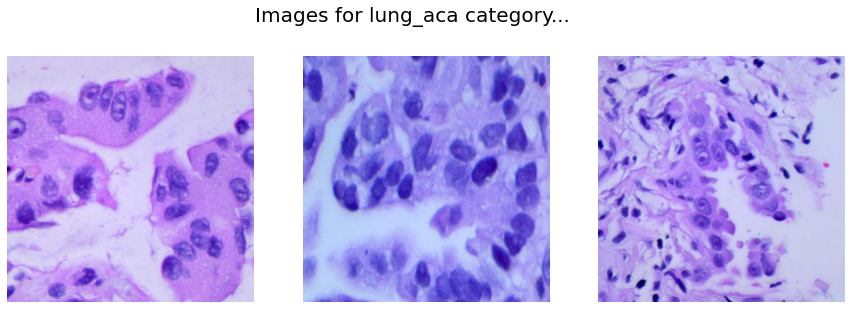

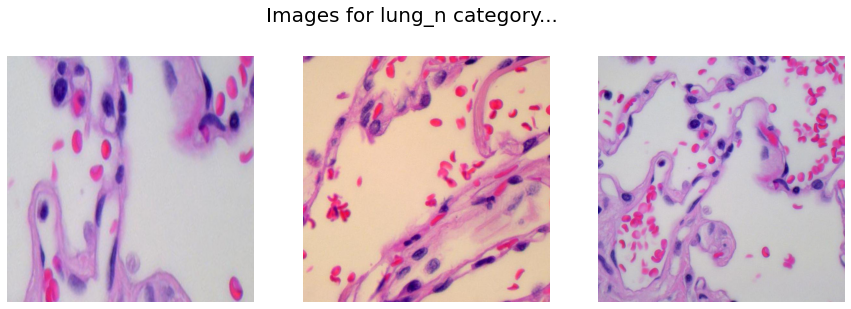

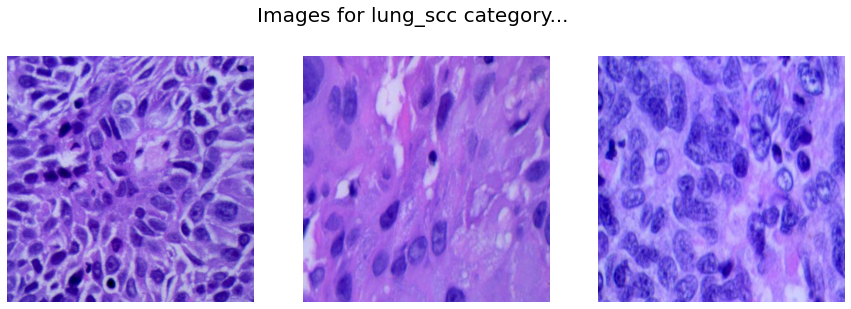

In [7]:
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
    
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    fig.suptitle(f'Images for {cat} category...', fontsize = 20)
    
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [11]:
# Convert images into NumPy arrays

IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [13]:
X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')
    
    for image in images:
        img = cv2.imread(image)
        
        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)
        #print(Y)
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [50]:
print(X)

[[[[240 195 211]
   [241 197 210]
   [242 198 211]
   ...
   [221  85 151]
   [223  84 151]
   [226  87 155]]

  [[241 196 212]
   [242 198 211]
   [243 199 212]
   ...
   [218  79 147]
   [223  83 154]
   [225  83 154]]

  [[242 197 213]
   [243 199 212]
   [244 200 213]
   ...
   [221  84 152]
   [219  81 152]
   [225  85 156]]

  ...

  [[221 113 186]
   [218 107 187]
   [210  99 179]
   ...
   [212 118 149]
   [221 126 160]
   [222 128 162]]

  [[218 106 178]
   [215 101 178]
   [206  93 173]
   ...
   [221 127 158]
   [226 132 166]
   [234 140 174]]

  [[215 100 167]
   [212  97 170]
   [202  91 165]
   ...
   [217 127 157]
   [217 128 161]
   [233 144 177]]]


 [[[219  89 114]
   [219  88 125]
   [220  92 139]
   ...
   [246 199 207]
   [246 200 206]
   [246 201 204]]

  [[213  82 115]
   [215  85 126]
   [210  85 134]
   ...
   [246 202 209]
   [246 202 208]
   [246 203 206]]

  [[218  91 130]
   [219  96 140]
   [210  95 139]
   ...
   [248 204 211]
   [248 204 210]
   [248 205

In [14]:
# Using One hot encoding output for predicting soft probabilities of image
# form each class with the highest probability for the class to which it belongs to

X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2022)

print(X_train.shape, X_val.shape)

# train_test_split also helps in shuffling the data as it splits the data 
# randomly in the given ratio

(12000, 256, 256, 3) (3000, 256, 256, 3)


# Model Development

We will implement a "Sequential model" which will contain the following parts:

Three Convolutional Layers followed by MaxPooling Layers.
The Flatten layer to flatten the output of the convolutional layer.
Then we will have two fully connected layers followed by the output of the flattened layer.
We have included some BatchNormalization layers to enable stable and fast training and a Dropout layer before the final layer to avoid any possibility of overfitting.
The final layer is the output layer which outputs soft probabilities for the three classes. 

In [16]:
model = keras.models.Sequential([
    layers.Conv2D(filters = 32,
                 kernel_size = (5, 5),
                 activation = 'relu',
                 input_shape = (IMG_SIZE, IMG_SIZE, 3),
                 padding = 'same'),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(filters = 64, 
                 kernel_size = (3, 3),
                 activation = 'relu',
                 padding = 'same'),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(filters=128,
                 kernel_size = (3, 3),
                 activation = 'relu',
                 padding = 'same'),
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    layers.Dense(256, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation = 'softmax')
])

In [17]:
# model  summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

From above we can see the change in the shape of the input image after passing through different layers. The CNN model we have developed contains about 33.5 Million parameters. This huge number of parameters and complexity of the model is what helps to achieve a high-performance model which is being used in real-life applications.

In [21]:
'''You must install pydot (`pip install pydot`) and install 
graphviz (see instructions at https://graphviz.gitlab.io/download/) 
for plot_model to work.
'''

#!pip install pydot
!pip install graphviz 

In [27]:
#from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import plot_model
import graphviz
import pydot

tf.keras.utils.plot_model(
model,
show_shapes = True,
show_dtype = True,
show_layer_activations = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [48]:
model.compile(
optimizer = 'adam',
loss = 'categorical_crossentropy',
metrics = ['accuracy'])

'''
While compiling a model we provide these three essential parameters:

optimizer – This is the method that helps to optimize the cost function by using gradient descent.
loss – The loss function by which we monitor whether the model is improving with training or not.
metrics – This helps to evaluate the model by predicting the training and the validation data.
'''

'\nWhile compiling a model we provide these three essential parameters:\n\noptimizer – This is the method that helps to optimize the cost function by using gradient descent.\nloss – The loss function by which we monitor whether the model is improving with training or not.\nmetrics – This helps to evaluate the model by predicting the training and the validation data.\n'

In [29]:
'''
Callbacks are used to check whether the model is improving with each epoch or not.

ReduceLROnPlateau - decreases the learning rate further
EarlyStopping - if model performance is not improving then training will be stopped
Custome Callbacks - to stop training if the desired results have been obtained early
'''

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('val_accuracy') > 0.9:
            print('\n Validation accuracy has reached 90% so, stopping further training')
            self.model.stop_training = True
            
es = EarlyStopping(patience = 3,
                  monitor = 'val_accuracy',
                  restore_best_weights = True)

lr = ReduceLROnPlateau(monitor = 'val_loss',
                      patience = 2,
                      factor = 0.5,
                      verbose = 1)

In [30]:
# Training the model

history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val),
                   batch_size = BATCH_SIZE,
                   epochs = EPOCHS,
                   verbose = 1, 
                   callbacks = [es, lr, myCallback()])

Epoch 1/10
188/188 [==============================] - 995s 5s/step - loss: 0.3547 - accuracy: 0.8515 - val_loss: 17.7247 - val_accuracy: 0.3257 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 976s 5s/step - loss: 0.2154 - accuracy: 0.9132 - val_loss: 5.2418 - val_accuracy: 0.3657 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - 913s 5s/step - loss: 0.1750 - accuracy: 0.9312 - val_loss: 4.8056 - val_accuracy: 0.3460 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - 776s 4s/step - loss: 0.1358 - accuracy: 0.9482 - val_loss: 19.2638 - val_accuracy: 0.3533 - lr: 0.0010
Epoch 5/10
188/188 [==============================] - 766s 4s/step - loss: 0.1132 - accuracy: 0.9545 - val_loss: 0.4682 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 6/10
188/188 [==============================] - 865s 5s/step - loss: 0.1051 - accuracy: 0.9612 - val_loss: 20.7973 - val_accuracy: 0.3257 - lr: 0.0010
Epoch 7/10
188/188 [==============================] - ETA: 0s

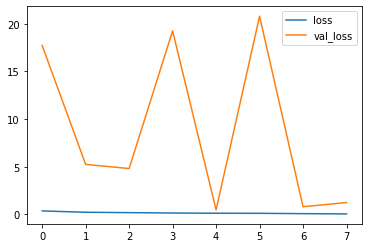

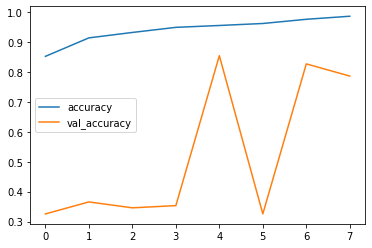

In [31]:
# visualizing training and validation accuracy

history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [32]:
# predicting the calss for validation data through the model developed

Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis = 1)
Y_pred = np.argmax(Y_pred, axis = 1)

94/94 [==============================] - 39s 409ms/step


In [33]:
# plotting confusion matrix and classification report

metrics.confusion_matrix(Y_val, Y_pred)

array([[617,  29, 341],
       [  4, 973,   0],
       [ 49,  16, 971]], dtype=int64)

In [34]:
print(metrics.classification_report(Y_val, Y_pred, target_names = classes))

              precision    recall  f1-score   support

    lung_aca       0.92      0.63      0.74       987
      lung_n       0.96      1.00      0.98       977
    lung_scc       0.74      0.94      0.83      1036

    accuracy                           0.85      3000
   macro avg       0.87      0.85      0.85      3000
weighted avg       0.87      0.85      0.85      3000



# Model Development - InceptionV3

In [54]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
input_shape = (IMG_SIZE, IMG_SIZE, 3),
weights = 'imagenet',
include_top = False)

In [55]:
len(pre_trained_model.layers)

311

'''
This is how deep this model is this also justifies why this model is highly effective in extracting useful features from images which helps us to build classifiers.

The parameters of a model we import are already trained on millions of images and for weeks so, we do not need to train them again.
'''

In [56]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [57]:
# 'Mixed7' is one of the layers in the inception network whose outputs we will use to build the classifier

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 14, 14, 768)


In [65]:
from keras import optimizers, losses, activations, models

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.SGD(learning_rate=1e-4, 
                                       momentum=0.9),
              metrics=['accuracy'])

In [61]:
# defining layers of model

x = layers.Flatten()(last_output)
x = layers.Dense(256, activation = 'relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(0.3)(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(3, activation = 'softmax')(x)

model = keras.Model(pre_trained_model.input, output)

In [62]:
# Callback

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('val_accuracy') > 0.9:
            print('\n Validation accuracy has reached upto 90%')
            self.model.stop_training = True
            
es = EarlyStopping(patience = 3,
                  monitor = 'val_accuracy',
                  restore_best_weights = True)

lr = ReduceLROnPlateau(monitor = 'val_loss',
                      patience = 2,
                      factor = 0.5,
                      verbose = 1)

In [67]:
# training the model

history = model.fit(X_train, Y_train,
                   validation_data = (X_val, Y_val),
                   batch_size = BATCH_SIZE,
                   epochs = EPOCHS,
                   verbose = 1,
                   callbacks = [es, lr, myCallback()])

Epoch 1/10
188/188 [==============================] - ETA: 0s - loss: 1.0986 - accuracy: 0.3344 

ValueError: in user code:

    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\engine\training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\engine\training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\engine\training.py", line 1667, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\nishantjairath\Anaconda3\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 3) are incompatible
